<a href="https://colab.research.google.com/github/tzev/LinkedIn-Project/blob/main/TradingSignals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
% pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
ark = yf.download('ARKK')
ark.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-10-31,20.420000,20.420000,20.379999,20.379999,18.697985,2700
2014-11-03,20.490000,20.490000,20.350000,20.379999,18.697985,2300
2014-11-04,20.200001,20.270000,20.200001,20.260000,18.587891,7900
2014-11-05,20.510000,20.510000,20.000000,20.000000,18.349352,14900
2014-11-06,20.090000,20.139999,20.070000,20.139999,18.477795,2000


In [ ]:
ark_ticker = yf.Ticker('ARKK')
ark_ticker.info

{'52WeekChange': None,
 'SandP52WeekChange': None,
 'algorithm': None,
 'annualHoldingsTurnover': None,
 'annualReportExpenseRatio': None,
 'ask': 117.14,
 'askSize': 800,
 'averageDailyVolume10Day': 4894440,
 'averageVolume': 6527521,
 'averageVolume10days': 4894440,
 'beta': None,
 'beta3Year': 1.56,
 'bid': 117.13,
 'bidSize': 800,
 'bookValue': None,
 'category': 'Mid-Cap Growth',
 'circulatingSupply': None,
 'companyOfficers': [],
 'currency': 'USD',
 'dayHigh': 119.55,
 'dayLow': 116.8,
 'dividendRate': None,
 'dividendYield': None,
 'earningsQuarterlyGrowth': None,
 'enterpriseToEbitda': None,
 'enterpriseToRevenue': None,
 'enterpriseValue': None,
 'exDividendDate': None,
 'exchange': 'PCX',
 'exchangeTimezoneName': 'America/New_York',
 'exchangeTimezoneShortName': 'EDT',
 'expireDate': None,
 'fiftyDayAverage': 120.901146,
 'fiftyTwoWeekHigh': 159.7,
 'fiftyTwoWeekLow': 85.27,
 'fiveYearAverageReturn': 0.43400002,
 'fiveYearAvgDividendYield': None,
 'forwardEps': None,
 'forwa

In [ ]:
SMA_10 = ark['Close'].rolling(window = 10).mean()
SMA_25 = ark['Close'].rolling(window = 25).mean()
SMA_50 = ark['Close'].rolling(window = 50).mean()
SMA_100 = ark['Close'].rolling(window = 100).mean()

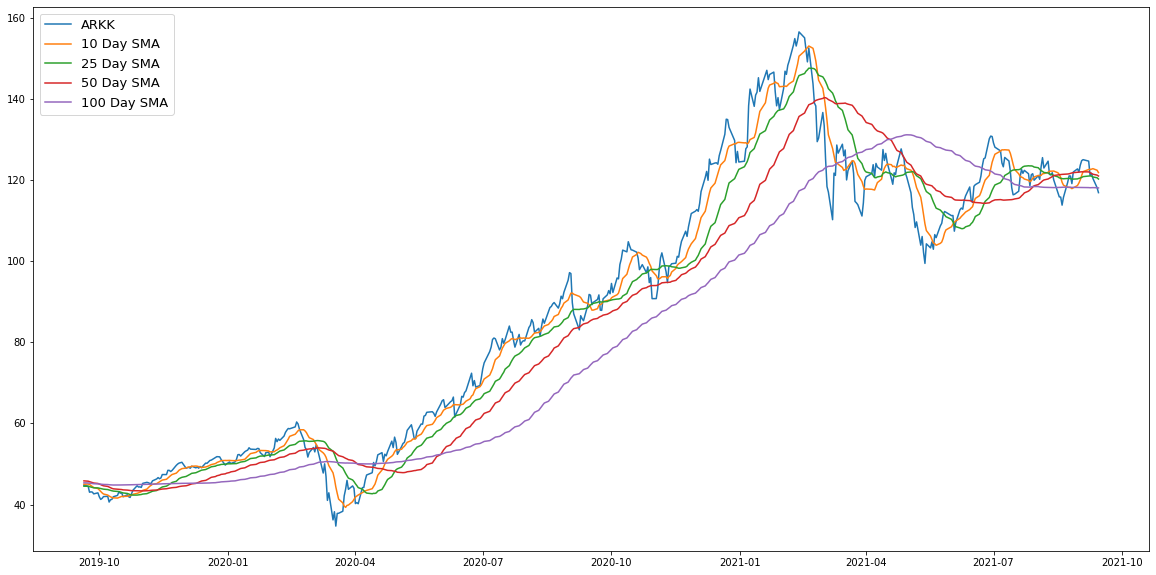

In [ ]:
# taking last 500 trading days
plt.figure(figsize=(20, 10))
plt.plot(ark['Close'][-500:], label='ARKK')
plt.plot(SMA_10[-500:], label='10 Day SMA')
plt.plot(SMA_25[-500:], label='25 Day SMA')
plt.plot(SMA_50[-500:], label='50 Day SMA')
plt.plot(SMA_100[-500:], label='100 Day SMA')
plt.legend(loc='upper left', fontsize=13)

In [ ]:
def get_points_above(sma_low, sma_high):
    points_above = {}
    for pair in zip(sma_low, sma_high):
        if pair[0] >= pair[1]:
            date = sma_low[sma_low == pair[0]].index[0]
            points_above[date] = pair[0]
            
    points_above = pd.Series(points_above, name='Price_Points')
    points_above.index.name = 'Date'
            
    return points_above
points_above_SMA_50 = get_points_above(SMA_25, SMA_50)

In [ ]:
SMA_25 = SMA_25.reset_index()
SMA_50 = SMA_50.reset_index()

In [ ]:
crossovers = pd.DataFrame()
crossovers['Dates'] = SMA_25['Date']
crossovers['Price'] = [i for i in ark['Close']]
crossovers['SMA_25'] = SMA_25['Close']
crossovers['SMA_50'] = SMA_50['Close']
crossovers['position'] = crossovers['SMA_25'] >= crossovers['SMA_50']
crossovers['pre-position'] = crossovers['position'].shift(1)
crossovers['Crossover'] = np.where(crossovers['position'] == crossovers['pre-position'], False, True)
crossovers['Crossover'][0] = False
print(crossovers)

          Dates       Price    SMA_25  ...  position  pre-position Crossover
0    2014-10-31   20.379999       NaN  ...     False           NaN     False
1    2014-11-03   20.379999       NaN  ...     False         False     False
2    2014-11-04   20.260000       NaN  ...     False         False     False
3    2014-11-05   20.000000       NaN  ...     False         False     False
4    2014-11-06   20.139999       NaN  ...     False         False     False
...         ...         ...       ...  ...       ...           ...       ...
1721 2021-09-08  121.169998  121.0676  ...     False         False     False
1722 2021-09-09  121.709999  121.0048  ...     False         False     False
1723 2021-09-10  120.459999  120.8004  ...     False         False     False
1724 2021-09-13  118.169998  120.6068  ...     False         False     False
1725 2021-09-14  116.934998  120.2962  ...     False         False     False

[1726 rows x 7 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
crossovers = crossovers.loc[crossovers['Crossover'] == True]
crossovers = crossovers.reset_index()
crossovers = crossovers.drop(['position', 'pre-position', 'Crossover', 'index'], axis=1)
crossovers['Signal'] = np.nan
crossovers['Binary_Signal'] = 0.0
for i in range(len(crossovers['SMA_25'])):
    if crossovers['SMA_25'][i] > crossovers['SMA_50'][i]:
        crossovers['Binary_Signal'][i] = 1.0
        crossovers['Signal'][i] = 'Buy'
    else:
        crossovers['Signal'][i] = 'Sell'
print(crossovers)

        Dates       Price     SMA_25     SMA_50 Signal  Binary_Signal
0  2015-01-26   20.750000   20.12184   20.09748    Buy            1.0
1  2015-04-06   20.969999   20.94072   20.95222   Sell            0.0
2  2015-04-22   21.760000   21.18924   21.18084    Buy            1.0
3  2015-06-01   21.520000   21.22084   21.24648   Sell            0.0
4  2015-06-11   21.780001   21.35988   21.34744    Buy            1.0
5  2015-07-29   21.820000   21.53696   21.56498   Sell            0.0
6  2015-11-06   20.848000   19.80656   19.80306    Buy            1.0
7  2016-01-11   18.170000   20.48124   20.51392   Sell            0.0
8  2016-03-17   18.100000   17.12452   17.11664    Buy            1.0
9  2016-05-20   18.200001   18.83544   18.84880   Sell            0.0
10 2016-06-20   19.670000   19.18148   19.15628    Buy            1.0
11 2016-10-31   19.917000   21.09516   21.10810   Sell            0.0
12 2016-12-15   20.781000   20.46868   20.42712    Buy            1.0
13 2018-04-16   40.2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-pack

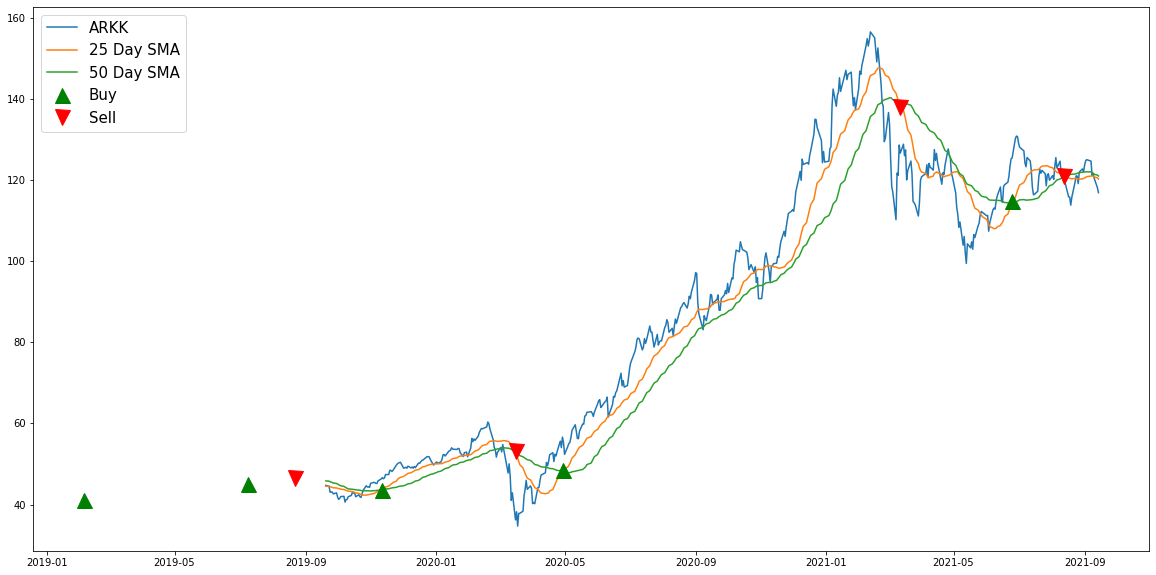

In [ ]:
# taking last 500 trading days
SMA_25 = ark['Close'].rolling(window=25).mean()
SMA_50 = ark['Close'].rolling(window=50).mean()
plt.figure(figsize=(20, 10))
plt.plot(ark['Close'][-500:], label='ARKK')
plt.plot(SMA_25[-500:], label='25 Day SMA')
plt.plot(SMA_50[-500:], label='50 Day SMA')
plt.plot(crossovers.loc[crossovers.Signal == 'Buy']['Dates'][-5:], 
         crossovers['SMA_25'][crossovers.Signal == 'Buy'][-5:],
        '^', markersize=15, color='g', label='Buy')
plt.plot(crossovers.loc[crossovers.Signal == 'Sell']['Dates'][-4:], 
         crossovers['SMA_25'][crossovers.Signal == 'Sell'][-4:],
        'v', markersize=15, color='r', label='Sell')
plt.legend(loc='upper left', fontsize=15)